<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab09: ML Basics: Unsupervised Learning - Tutorial Extra


```









```

# Load Imports and Library of Helper Functions

- Run this cell to use its functions later. Contains plotting functions.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.simplefilter("ignore", UserWarning)


def one_hot_encode(df, columns_to_encode):
    df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in columns_to_encode:
        if col in df_encoded.columns: #Check if the column exists.
            one_hot = pd.get_dummies(df_encoded[col], prefix=col)
            df_encoded = pd.concat([df_encoded, one_hot], axis=1)
            df_encoded = df_encoded.drop(col, axis=1) #remove the original column
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df_encoded

def _plot_sihouette_score(silhouette_scores, param_range, param_name):
    plt.figure(figsize=(10, 3))
    plt.plot(param_range, silhouette_scores, marker='o', linestyle='--', color='r')
    plt.title('Silhouette Analysis')
    plt.xlabel(param_name.upper())
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
def _plot_wcss_elbow_method(n_clusters_range, wcss):
    plt.plot(n_clusters_range, wcss, marker='o')
    plt.title('Elbow Method:')
    plt.xlabel('Number of Clusters (n_clusters)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(n_clusters_range)
    plt.grid(True)
    plt.show()
    
def get_centroids_from_clusters(X:np.array, cluster_labels:list):
    centroids = []
    for c_id in np.unique(cluster_labels):
        p = X[cluster_labels == c_id]
        c = p.mean(axis=0)
        centroids += [c]
    return centroids

def _plot_voronoi_2d(point, labels):
    def plot_voronoi_2d( vor, data_points, data_label, plot_title, sub_title):
        voronoi_plot_2d(vor, show_vertices=True, line_alpha=0.5, point_size=15)
        
        plt.plot(data_points[:, 0], data_points[:, 1], "k.", markersize=2, label=data_label)
        plt.ylabel('y')
        plt.xlabel('x')
        plt.title(plot_title, fontsize=10, fontweight='bold')
        plt.gca().text(x=-0.05,y=-0.15, s=sub_title, fontsize=6, fontweight='bold', transform=plt.gca().transAxes)
        
        for region in vor.regions:
            if not -1 in region:
                polygon = [vor.vertices[i] for i in region]
                plt.fill(*zip(*polygon), alpha=0.2)
        
        current_xlim = plt.gca().get_xlim()
        current_ylim = plt.gca().get_ylim()
        x_margin = 0.3 * (current_xlim[1] - current_xlim[0])
        y_margin = 0.3 * (current_ylim[1] - current_ylim[0])
        plt.xlim(current_xlim[0] - x_margin, current_xlim[1] + x_margin)
        plt.ylim(current_ylim[0] - y_margin, current_ylim[1] + y_margin)
                
    centroid_points = get_centroids_from_clusters(points, labels)
    vor = Voronoi(centroid_points) # compute Voronoi tesselation
    
    plot_voronoi_2d( vor, points, 
                    data_label='', 
                    plot_title='Voronoi Cells for Clusters',
                    sub_title='')
    
def _plot_centroid_lines(data, labels):
    centroids = get_centroids_from_clusters(data, labels)
    for cid, centr in enumerate(centroids):
        plt.scatter([centr[0]], [centr[1]], c='red', s=50, marker='x')
        c_data = data[data['Cluster Label']==cid]
        for c in c_data.iterrows():
            plt.plot([c[1][0], centr[0]], [c[1][1], centr[1]], c='k', lw=0.25, ls='dashed', alpha=0.5 )
            
def plot_dendrogram(model, cutpoint_1=7, cutpoint_2=15, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel("Number of points in node \n(or index of point if no parenthesis).")
    plt.xlabel('Cophenetic distance')
    plt.gca().axvline(cutpoint_1, color='r',ls='--',lw=2, label=f'Arbitrary cut-point {cutpoint_1}')
    plt.gca().axvline(cutpoint_2, color='g',ls='--',lw=0.5, label=f'Arbitrary cut-point {cutpoint_2}')
    plt.legend()
    print('The arbitrary cut-point is used to select the number of desired clusters, based on the Cophenetic distance.')
    print('Note: Cophenetic distance is the cluster separation distance; longer legs indicates greater separation distances.')
    print('      Right-hand numbers with parentheses    - specify how many records are within a cluster / "leg".')
    print('                         without parentheses - specify a cluster with a single record\'s index number.')
    plt.show()


def plotly_map(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], zoom=5, WRITE=False, WRITE_FN=None):
    """ 
    @WRITE_FN - do not include extension - i.e. `.png` or `.html`, as both files will be written.
    Docs:   https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox.html
            https://plotly.com/python/mapbox-density-heatmaps/
    """
    pio.templates.default = 'plotly_white' # 'plotly_dark'
    fig = px.density_mapbox(df, 
                            lat=latlng_cols[0], 
                            lon=latlng_cols[1], 
                            z=z,
                            radius=5,
                            center=dict(lat=13.6, lon=100.4), zoom=zoom,
                            mapbox_style=["open-street-map",'carto-darkmatter'][0],
                            custom_data=custom_data_cols,
                           )

    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )

def plotly_map_color_points(df, latlng_cols=('lat','lng'), z=None, custom_data_cols=[], custom_text=[], 
                            WRITE=False, WRITE_FN=None, SHOW=False ):
    """
    See - https://plotly.com/python/mapbox-layers/
    """
    fig = px.scatter_mapbox(df, 
                         lat=df[latlng_cols[0]],
                         lon=df[latlng_cols[1]],
                         color=z, # which column to use to set the color of markers
                         #hover_name="country", # column added to hover information
                         # size=markersize, # size of markers
                        center=dict(lat=13.6, lon=100.4), zoom=4,
                        mapbox_style=["open-street-map",'carto-darkmatter'][0],
                        custom_data=custom_data_cols,
                        )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    if custom_text:
        fig.update_traces(
            hovertemplate="<br>".join(custom_text)
        )
    if SHOW:
        fig.show(config={'displayModeBar': False} )
    if WRITE:
        if WRITE_FN != None and isinstance(WRITE_FN, str) and len(WRITE_FN)>4:
            ofn = f'{WRITE_FN}_MapPlot_{TIMESTAMP_FILENAME()}'
            fig.write_image(ofn+'.png')
            fig.write_html(ofn+'.html', full_html=False, include_plotlyjs=False, include_mathjax=False )
    return fig
    
def _plot_scatter_per_cluster(df, labels, 
                              xlabel='capacity (mw)',
                              ylabel='avg. annual output (mwh)',
                              hue='avg. annual output (mwh)'):
    l = 2 if len(np.unique(labels)) % 2==0 else 1
    # Create subplots with two clusters in each row
    fig, axes = plt.subplots(len(np.unique(labels)) // l, l, figsize=(12, 10), sharey=True, sharex=True)
    # Flatten the axes array to iterate through subplots
    axes = axes.ravel()
    
    # Loop through each cluster and plot it
    for cluster_id in np.unique(labels):
        # Filter data for the current cluster
        cluster_data = df[df['Cluster Label']==cluster_id]
        sns.scatterplot(data=cluster_data, x=xlabel, y=ylabel, hue=hue, palette='viridis', ax=axes[cluster_id])
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel(xlabel.title())
    plt.ylabel(ylabel.title())
    
    # Adjust subplot spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

```

















```

# Extra: "Weakly Predictive Clustering" of 3 Flower types (Iris Dataset - With Ground Truth)
- This time we will look at the Iris dataset, where we know that `there are 3 types of iris flowers`.
- Therefore, we know that there should be 3 clusters of flowers to find.
- `What do you think the data will indicate as the best separation of number of flowers?` Let's take a look:

Iris Dataset (Fisher, 1936):
- Dataset Source: https://archive.ics.uci.edu/dataset/53/iris

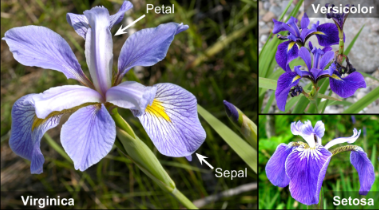

Image credit: Photos reproduced from the corresponding Wikipedia pages. Iris virginica photo by Frank Mayfield (Creative Commons BY-SA 2.0), Iris versicolor photo by D. Gordon E. Robertson (Creative Commons BY-SA 3.0), Iris setosa photo public domain.


In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
print('Num of Classes',len(list(set(iris.target))), iris.target_names)
print('Features:', iris['feature_names'])
data = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=list(range(len(iris['feature_names']))) + ['target'])
data.info()

In [ ]:
sns.pairplot(data, hue="target", kind="kde", height=1.5, markers=["o", "s", "D"])

- In some of the pairplot (with Kernal Density Estimation-KDE) subplots, we might occasionally see two groups rather than three...

##### Prepare Data for Clustering (Only `X` data, no `y`)

In [ ]:
X = data.drop(columns=['target'])

- Scale the selected data (`X` only) for modelling, encode and handle missing values.

In [ ]:
from sklearn.preprocessing import StandardScaler

# X_encoded = one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Parameter Search & Silhouette Score:

- Using a hyperparameter grid search, we can explore the `silhouette` metric score for different model parameter values, and choose the best performing parameter configuration:

In [ ]:
from sklearn.mixture import GaussianMixture

silhouette_scores = []
n_components_range = np.arange(1,20,1)
for n_components in n_components_range:
    model = GaussianMixture(n_components=n_components)
    model = model.fit(X_scaled)
    labels = model.predict(X_scaled)
    if len(np.unique(labels))>1:
        score = silhouette_score(X_scaled, labels)
    else:
        score = float('nan')
    silhouette_scores += [ score ]



def get_best( param_range, silhouette_scores ):
    dfr = pd.DataFrame([n_clusters_range, silhouette_scores]).T.rename(columns={0:'Param', 1:'Silhouette Score'}).sort_values(by=['Silhouette Score'], ascending=False).dropna()
    display(dfr)
    best =  dfr.iloc[0].Param
    print('Best Parameter is: ',best)
    return best

_plot_sihouette_score(silhouette_scores, param_range=n_components_range, param_name='n_components Parameter')
best = get_best( n_components_range, silhouette_scores )
best


In [ ]:
print('Using Best n_components Parameter:', best)

model = GaussianMixture(n_components=int(best))
model = model.fit(X_scaled)
labels = model.predict(X_scaled)
print('Unique Labels', np.unique(labels), f'\t DF_n={len(data)}, Cluster_n={len(labels)}' )
data['Cluster Label'] = pd.Series(labels, index=data.index[:len(labels)])

centroid_points = get_centroids_from_clusters(data, labels)
sns.scatterplot(data=data, x=0, y=1, hue='Cluster Label', palette='viridis')
sns.scatterplot(data=pd.DataFrame(centroid_points), x=0, y=1, color='red')
_plot_centroid_lines(data, labels)

- The GMM found the best number of (statistically) separating groups as 2 in the Iris dataset.
- Which is surprising as we know there are three (human-defined) classes.

#### Prediction by Clusterings:

- It's possible to use this clustering mechanism as a classification prediction tool also.
- We know that there are `3 Iris classes`, therefore we can cluster the data based on that information, and make prediction from the outcome model.

In [ ]:
from sklearn.model_selection import train_test_split
X,y = X_scaled, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
model = GaussianMixture(n_components=3, random_state=0)
model = model.fit(X_train)
labels = model.predict(X_test)

In [ ]:
print( 'Predicted Cluster Labels:\n',labels) 
print( 'True Labels:\n',y_test )

- The clustering algorithm has no concept of naming a cluster or of the target classes.
- Therefore, we can manually map the cluster labels to classes; so that `Cluster 1 maps to Class 1`, etc.

In [ ]:
mapping = {2:2, 0:1, 1:0}
mapped_cluster_labels1 = [mapping.get(v,None) for v in labels]
np.array(mapped_cluster_labels1)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, classification_report

def _show_classification_report( y_true, y_pred, target_names):
    '''
        Function to print performance metrics
    '''
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, average='weighted')
    specificity = recall_score(y_true, y_pred, pos_label=0, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Classification Report:")
    class_report = classification_report(y_true, y_pred, target_names=target_names)
    print(class_report)
    res = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    return pd.json_normalize(res, sep='_')


_ = _show_classification_report( y_test , mapped_cluster_labels1, target_names=iris.target_names)

- The performance is pretty good!  `F1-Score at 0.96` (weighted avg).
- This suggests:
    1. the GMM algorithm is good at finding the 3 separate groups in this dataset, and
    2. the data defines those three groups quite well.

```






```
<p style="text-align:center;">That's it! Congratulations! </p>